Script to analyze the multiple myeloma results. This includes plotting the representative tree and gene expression analysis.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from src_python.cell_tree import CellTree

In [10]:
def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_nodes = len(parent_vector)
    n_leaves = int((n_nodes+1)/2)
    n_mutations = len(mutation_indices)

    mutation_matrix = np.zeros((n_nodes, n_mutations), dtype=int)

    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves].T

def are_all_arrays_identical(arrays_list):
    first_array = arrays_list[0]
    return all(np.array_equal(first_array, array) for array in arrays_list[1:])

In [11]:
# with open("../data/input_data/gencode.v21.annotation.gtf", 'r') as file:
#     for line in file:
#         if line.startswith("#"):
#                 continue
#         fields = line.strip().split('\t')
#         if fields[2] == 'gene':
#             attributes = {key_value.split(' ')[0]: key_value.split(' ')[1].strip('"') for key_value in
#                           fields[8].split('; ') if key_value}
#             gene_names.append([fields[0], fields[3], fields[4], attributes["gene_name"]])
# 
# df = pd.DataFrame(gene_names, columns=['chromosome', 'start', 'end', 'gene'])
# df['start'] = df['start'].astype(int)
# df['end'] = df['end'].astype(int)
# df.to_csv("../data/input_data/mm34/gene_positions.csv", index=False)

def convert_location_to_gene(locs):

    loc_to_gene = []

    df = pd.read_csv("../data/input_data/mm34/gene_positions.csv", index_col=False)
    for location in locs:
        chrom, pos = location.split(":")[0], location.split(":")[1]
        pos = int(pos)
        matching_rows = df[(df['chromosome'] == chrom) & (df['start'] <= pos) & (df['end'] >= pos)]
        matching_genes = matching_rows['gene'].tolist()
        loc_to_gene.append(matching_genes)

    return loc_to_gene

In [12]:
n_bootstrap = 1000
np.random.seed(0)
study_num = "mm34"
reduced = "" # Reduced read counts are without lower quality cells.
use_summary_statistics = True # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False

path = rf"../data/results/{study_num}/bootstrap_1000_snvs_3000_only_ref_to_alt"

reference = pd.read_csv(rf'../data/input_data/{study_num}/ref{reduced}.csv', index_col=0)

if use_summary_statistics == False:
    os.makedirs(os.path.join(path, "sciterna_mutations_before_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_nodes_after_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_nodes_before_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_mutations_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_mutations_after_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_mut_indicator"), exist_ok=True)
    
    all_loci = reference.columns
    all_cells = reference.index
    mut_indicator = {}
    
    def mutations_node(parent_vector, mutation_indices, ct, node):
        n_cells = len(parent_vector)
        n_mutations = len(mutation_indices)
    
        mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)
    
        for mutation_idx, cell_idx in enumerate(mutation_indices):
            children = [c for c in ct.dfs_experimental(cell_idx)]
            for cell in children:  # Traverse all cells below the mutation cell
                mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation
    
        return mutation_matrix[node]
    
    for i in range(0, n_bootstrap):
        path_parent = os.path.join(path, "sciterna_parent_vec", f"sciterna_parent_vec_{i}.txt")
        
        if os.path.exists(os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{i}.txt")):
            continue
            
        path_mut_loc = os.path.join(path, "sciterna_mut_loc", f"sciterna_mut_loc_{i}.txt")
        path_selected = os.path.join(path, "sciterna_selected_loci", f"sciterna_selected_loci_{i}.txt")
        parent_vec = np.loadtxt(path_parent, dtype=int)
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        mutations = np.loadtxt(path_selected)
        for loci in all_loci:
            mut_indicator[loci] = []
    
        n_cells = int(((len(parent_vec)+1)/2))
        ct = CellTree(n_cells=n_cells, n_mut=len(mutations))
        ct.use_parent_vec(parent_vec)
        ct.mut_loc = mut_locs
        
        mutation_matrix = create_mutation_matrix(ct.parent_vec, ct.mut_loc, ct)
    
        for mi, mut in enumerate(mutations):
            mut_indicator[all_loci[int(mut)]].append(mutation_matrix[mi])
    
        for k in mut_indicator.keys():
            if len(mut_indicator[k]) > 1:
                if not are_all_arrays_identical(mut_indicator[k]):
                    print("Problem")
                else:
                    mut_indicator[k] = [mut_indicator[k][0]]
    
        dataframe = {}
    
        for key, value in mut_indicator.items():
            if len(value) > 0:
                dataframe[key] = pd.DataFrame([value[0]], columns=all_cells)
            else:
                dataframe[key] = pd.DataFrame([np.nan] * len(all_cells)).T
                dataframe[key].columns = all_cells
    
        df = pd.concat(dataframe.values(), axis=0)
        df.index = all_loci
        df.to_csv(os.path.join(path, "sciterna_mut_indicator", f"sciterna_mut_indicator_{i}.csv"), index=True)
        
        # optimize capture rate + purity to determine the majority metastasis branch
        branching_node = 0
        branching_nodes_max = 0
        for node in range(len(parent_vec)):
            if ct.isleaf(node):
                continue
    
            primary = 0
            metastasis = 0
            for sn in ct.dfs_experimental(node):
                if ct.isleaf(sn):
                    if study_num == "mm34":
                        if sn < 65:
                            primary += 1
                        elif sn >=65:
                            metastasis += 1
    
            capture_rate = metastasis/(n_cells - 65)
            purity = metastasis/(metastasis + primary)
            branching_nodes_new = capture_rate + purity
    
            if branching_nodes_max < branching_nodes_new:
                branching_node = node
                branching_nodes_max = branching_nodes_new
        print(branching_node, branching_nodes_max)
        if branching_nodes_max < 1.6:
            print("Potential problem: ", i)
    
        mutations_indices = mutations_node(parent_vec, mut_locs, ct, branching_node)
        mutations_branching = mutations[mutations_indices==1]
        np.savetxt(os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{i}.txt"), mutations_branching, fmt='%i')
    
        mutations_after_metastasis = []
        metastasis_nodes = [n for n in ct.dfs_experimental(branching_node) if ct.isleaf(n)]
        primary_nodes = [n for n in range(n_cells) if n not in metastasis_nodes]
    
        np.savetxt(os.path.join(path, rf"sciterna_nodes_after_branching\nodes_after_branching_{i}.txt"), metastasis_nodes, fmt='%i')
        np.savetxt(os.path.join(path, rf"sciterna_nodes_before_branching\nodes_before_branching_{i}.txt"), primary_nodes, fmt='%i')
    
        for ni, mut_loc in enumerate(mut_locs):
            if mut_loc in metastasis_nodes[1:]:
                mutations_after_metastasis.append(mutations[ni])
    
        mutations_before_metastasis = [m for m in mutations if m not in mutations_after_metastasis]
    
        np.savetxt(os.path.join(path, rf"sciterna_mutations_before_branching\mutations_before_branching_{i}.txt"), mutations_before_metastasis, fmt='%i')
        np.savetxt(os.path.join(path, rf"sciterna_mutations_after_branching\mutations_after_branching_{i}.txt"), mutations_after_metastasis, fmt='%i')
    
        # ct.mut_loc = []
        # graph = ct.to_graphviz()
        # for n in range(int((len(parent_vec)+1)/2)):
        #     if study_num == "34":
        #         graph.node(str(n), shape='circle', style='filled', color="red")
        #         if n in metastasis_nodes:
        #             graph.node(str(n), shape='circle', style='filled', color="blue")
        # 
        # graph.render(os.path.join(path, rf"ct_trees\ct_tree_{i}_branching"), format='png', cleanup=True)
        # 
        # for n in range(int((len(parent_vec)+1)/2)):
        #     if study_num == "34":
        #         if n < 65:
        #             graph.node(str(n), shape='circle', style='filled', color="red")
        #         elif n >=65 and reduced!="_reduced":
        #             graph.node(str(n), shape='circle', style='filled', color="blue")
        #         elif n >=64 and reduced=="_reduced":
        #             graph.node(str(n), shape='circle', style='filled', color="blue")
        #     else:
        #         if n < 23:
        #             graph.node(str(n), shape='circle', style='filled', color="red")
        #         elif n >=23 and reduced!="_reduced":
        #             graph.node(str(n), shape='circle', style='filled', color="blue")
        #         elif n >=22 and reduced=="_reduced":
        #             graph.node(str(n), shape='circle', style='filled', color="blue")
        # 
        # graph.render(os.path.join(path, rf"ct_trees\ct_tree_{i}"), format='png', cleanup=True)

In [13]:
if use_summary_statistics == False:
    primary = []
    metastasis = []
    primary_nodes = []
    metastasis_nodes = []
    branching = []
    for i in range(n_bootstrap):
        path_primary_node = os.path.join(path, rf"sciterna_nodes_before_branching\nodes_before_branching_{i}.txt")
        path_metastasis_node = os.path.join(path, rf"sciterna_nodes_after_branching\nodes_after_branching_{i}.txt")
        path_primary = os.path.join(path, rf"sciterna_mutations_before_branching\mutations_before_branching_{i}.txt")
        path_metastasis = os.path.join(path, rf"sciterna_mutations_after_branching\mutations_after_branching_{i}.txt")
        path_branching = os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{i}.txt")
        
        primary_data = np.loadtxt(path_primary, dtype=int)
        metastasis_data = np.loadtxt(path_metastasis, dtype=int)
        primary_nodes_data = np.loadtxt(path_primary_node, dtype=int)
        metastasis_nodes_data = np.loadtxt(path_metastasis_node, dtype=int)
        branching_data = np.loadtxt(path_branching, dtype=int)
        
        primary.extend(primary_data)
        metastasis.extend(metastasis_data)
        primary_nodes.extend(primary_nodes_data)
        metastasis_nodes.extend(metastasis_nodes_data)
        branching.extend(branching_data)
        
    unique_mutations_branching, counts_mutations_branching = np.unique(np.array(branching), return_counts=True)
    selected = np.loadtxt(os.path.join(path, "selected.txt"), delimiter=',', dtype=int)
    selected_mutations = np.unique(selected)

else:
    metastasis_nodes = np.loadtxt(os.path.join(path, "metastasis_nodes.txt"))

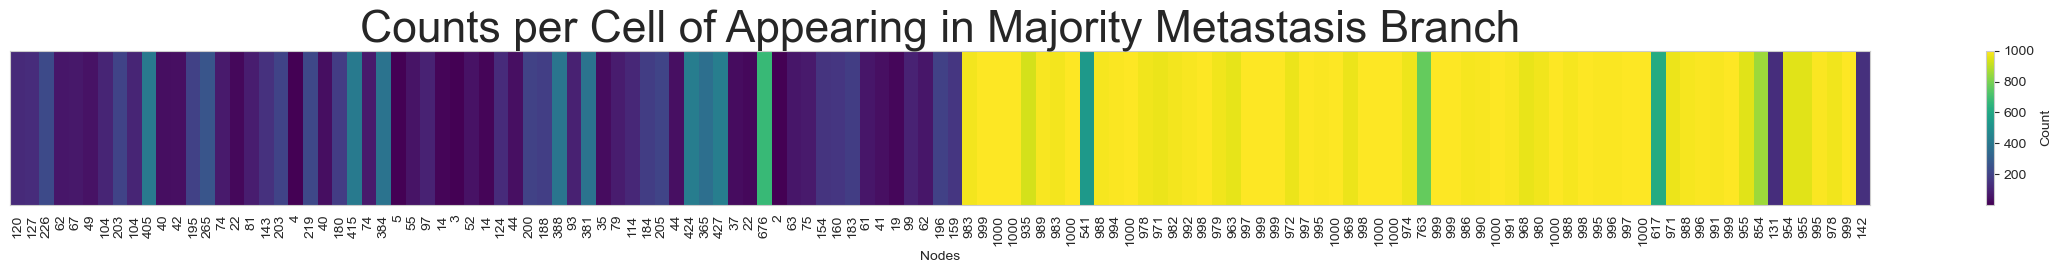

In [14]:
unique_cells, posterior_node_after_branching = np.unique(np.array(metastasis_nodes), return_counts=True)
heatmap_data = posterior_node_after_branching.reshape(1, -1)
plt.figure(figsize=(30, 2))
plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Count')
plt.xticks(ticks=np.arange(len(unique_cells)), labels=posterior_node_after_branching, rotation=90)
plt.yticks([])
plt.xlabel('Nodes')
plt.title('Counts per Cell of Appearing in Majority Metastasis Branch', fontsize=32)
plt.grid(False)

plt.show()

In [15]:
top_loci = np.loadtxt(rf"../data/results/{study_num}/bootstrap_1000_snvs_3000_only_ref_to_alt/top_3000_loci.txt", dtype=int)

In [16]:
selected_loci = reference.columns[top_loci]
selected_genes = convert_location_to_gene(selected_loci)

In [17]:
genes = []
for s in selected_genes:
    genes.extend(s)
gens, cnt = np.unique(genes, return_counts=True)

print(cnt[np.argsort(cnt)][-30:])
print(gens[np.argsort(cnt)][-30:])

[ 7  7  8  8  8  8  8  8  8  9  9  9  9 10 10 10 10 10 11 11 12 12 13 13
 15 15 16 16 22 22]
['AC016831.7' 'IKZF3' 'GSR' 'LINC-PINT' 'NEAT1' 'ELL2' 'MALAT1' 'COPA'
 'FNDC3B' 'NBPF9' 'HIBCH' 'SND1' 'FILIP1L' 'SPC24' 'ATF6' 'CMSS1'
 'MIR4435-1HG' 'RP5-857K21.4' 'VOPP1' 'STX2' 'KLHL24' 'NUP43' 'EMB'
 'IQGAP2' 'DCC' 'PELI1' 'NBPF14' 'VPS41' 'ATP11B' 'CTSB']


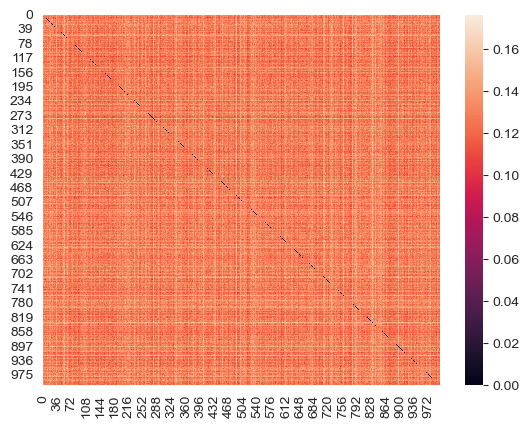

In [18]:
pairwise_distances = np.loadtxt(rf"../data/results/{study_num}/bootstrap_1000_snvs_3000_only_ref_to_alt/pairwise_distances.txt")
sns.heatmap(pairwise_distances, annot=False, fmt='%f')
plt.show()

In [19]:
mean1 = np.mean(pairwise_distances, axis=0)
mean2 = np.mean(pairwise_distances, axis=1)
print(np.argmin(mean1), np.min(mean2))

111 0.116868871


In [20]:
expression_counts_scaled = pd.read_csv(rf"../data/input_data/{study_num}/normalized_expression_data.csv", index_col=0)

expression_counts_scaled['sum_counts'] = expression_counts_scaled.sum(axis=1)
df_sorted = expression_counts_scaled.sort_values(by='sum_counts', ascending=False)
top_10000 = df_sorted.head(1000)
top_10000 = top_10000.drop(columns=['sum_counts'])
expression_counts_scaled = expression_counts_scaled.drop(columns=['sum_counts'])

In [21]:
top_5_indices = np.argsort(np.mean(expression_counts_scaled, axis=1))[-20:]
top_5_rows = expression_counts_scaled.iloc[top_5_indices]
top_5_rows

,SRR6710302,SRR6710303,SRR6710304,SRR6710305,SRR6710306,SRR6710307,SRR6710308,SRR6710309,SRR6710310,SRR6710311,...,SRR6710419,SRR6710420,SRR6710421,SRR6710422,SRR6710423,SRR6710424,SRR6710425,SRR6710426,SRR6710427,SRR6710428
RPLP0,4.052789,4.205018,2.892826,3.182429,2.424622,2.940255,3.733498,3.813041,3.839018,3.299541,...,3.800548,3.321432,3.850548,1.276240,4.084327,3.834946,3.185726,4.080309,3.792046,1.170684
MT-ND1,3.450909,3.918744,2.733308,1.105867,2.570812,3.652284,1.734510,4.825318,3.930632,3.326922,...,3.227616,3.742954,4.426422,5.843778,4.214899,3.895042,4.273283,4.322341,3.931659,5.741741
RPL3,3.829481,4.253966,2.436665,2.891775,3.339409,2.977467,2.724903,3.621528,3.467082,3.219246,...,3.569345,3.945954,3.733172,2.036520,4.098009,3.769622,3.440701,3.999787,3.699334,2.411122
FTL,4.084148,3.169214,1.675001,4.433046,2.912704,3.092530,3.155640,3.488797,3.349810,4.396233,...,4.267147,4.038863,4.421296,1.459965,4.020900,4.116594,3.741602,3.772768,4.573680,0.059125
HSP90B1,3.981635,4.002323,3.485393,3.890676,2.615718,4.761160,3.914738,2.667658,2.616026,3.665333,...,3.703537,3.369971,3.180423,2.476146,4.390994,4.492479,3.713136,3.239824,3.411085,0.742198
MT-CO3,3.840219,3.981831,3.014989,3.438848,1.143280,4.173767,2.219204,4.898689,4.075837,2.824117,...,3.578640,3.867228,3.642958,5.842182,4.294509,3.932356,4.125423,4.423073,4.022479,6.176663
MT-ATP6,3.862584,4.209202,2.601453,3.506177,2.481377,3.957983,2.107899,5.237231,4.059270,2.957184,...,3.979762,3.993861,3.632995,5.706471,4.009963,4.133778,4.076952,4.265537,4.031388,5.956948
MT-CYB,3.221334,4.442664,3.494427,4.301222,1.647735,4.283514,2.001125,5.750223,4.596965,3.468674,...,4.090785,4.264968,4.302324,6.168823,4.442017,4.535130,4.203808,4.300470,4.132424,6.429176
IGKC,3.958740,4.410582,4.600001,5.446403,4.792620,4.599129,4.810504,4.924301,4.262303,3.961478,...,2.634183,4.193985,3.307730,1.669853,3.400143,3.216957,3.274424,3.990241,3.357671,1.301760
MT-ND2,3.967550,4.598783,0.814788,2.164351,3.491225,3.504620,3.321009,5.421233,4.530130,3.656755,...,3.910153,4.393842,4.051620,6.175791,4.638553,4.683191,4.433494,4.892366,4.463094,6.209144


In [22]:
categories = {
    "Most expressed": ["IGKV2-28", "B2M", "MALAT1"],
    "largest_difference_groups": ['IGJ', 'FCRL2', 'CD74', 'ABCA1', 'TBL1XR1', 'HLA-B'], #'CTSB'
    "selected": ['CTSB'],
    "most_mutated": ['DCC', 'PELI1', 'NBPF14', 'VPS41', 'ATP11B'] # 'CTSB'
}

filtered_df_top_genes = pd.DataFrame()

for category, genes in categories.items():
    category_genes = expression_counts_scaled[expression_counts_scaled.index.isin(genes)]
    category_row_sums = category_genes.sum(axis=1)
    top_genes = category_row_sums.nlargest(7).index
    filtered_df_top_genes = pd.concat([filtered_df_top_genes, expression_counts_scaled.loc[top_genes]])

<Figure size 4000x1600 with 0 Axes>

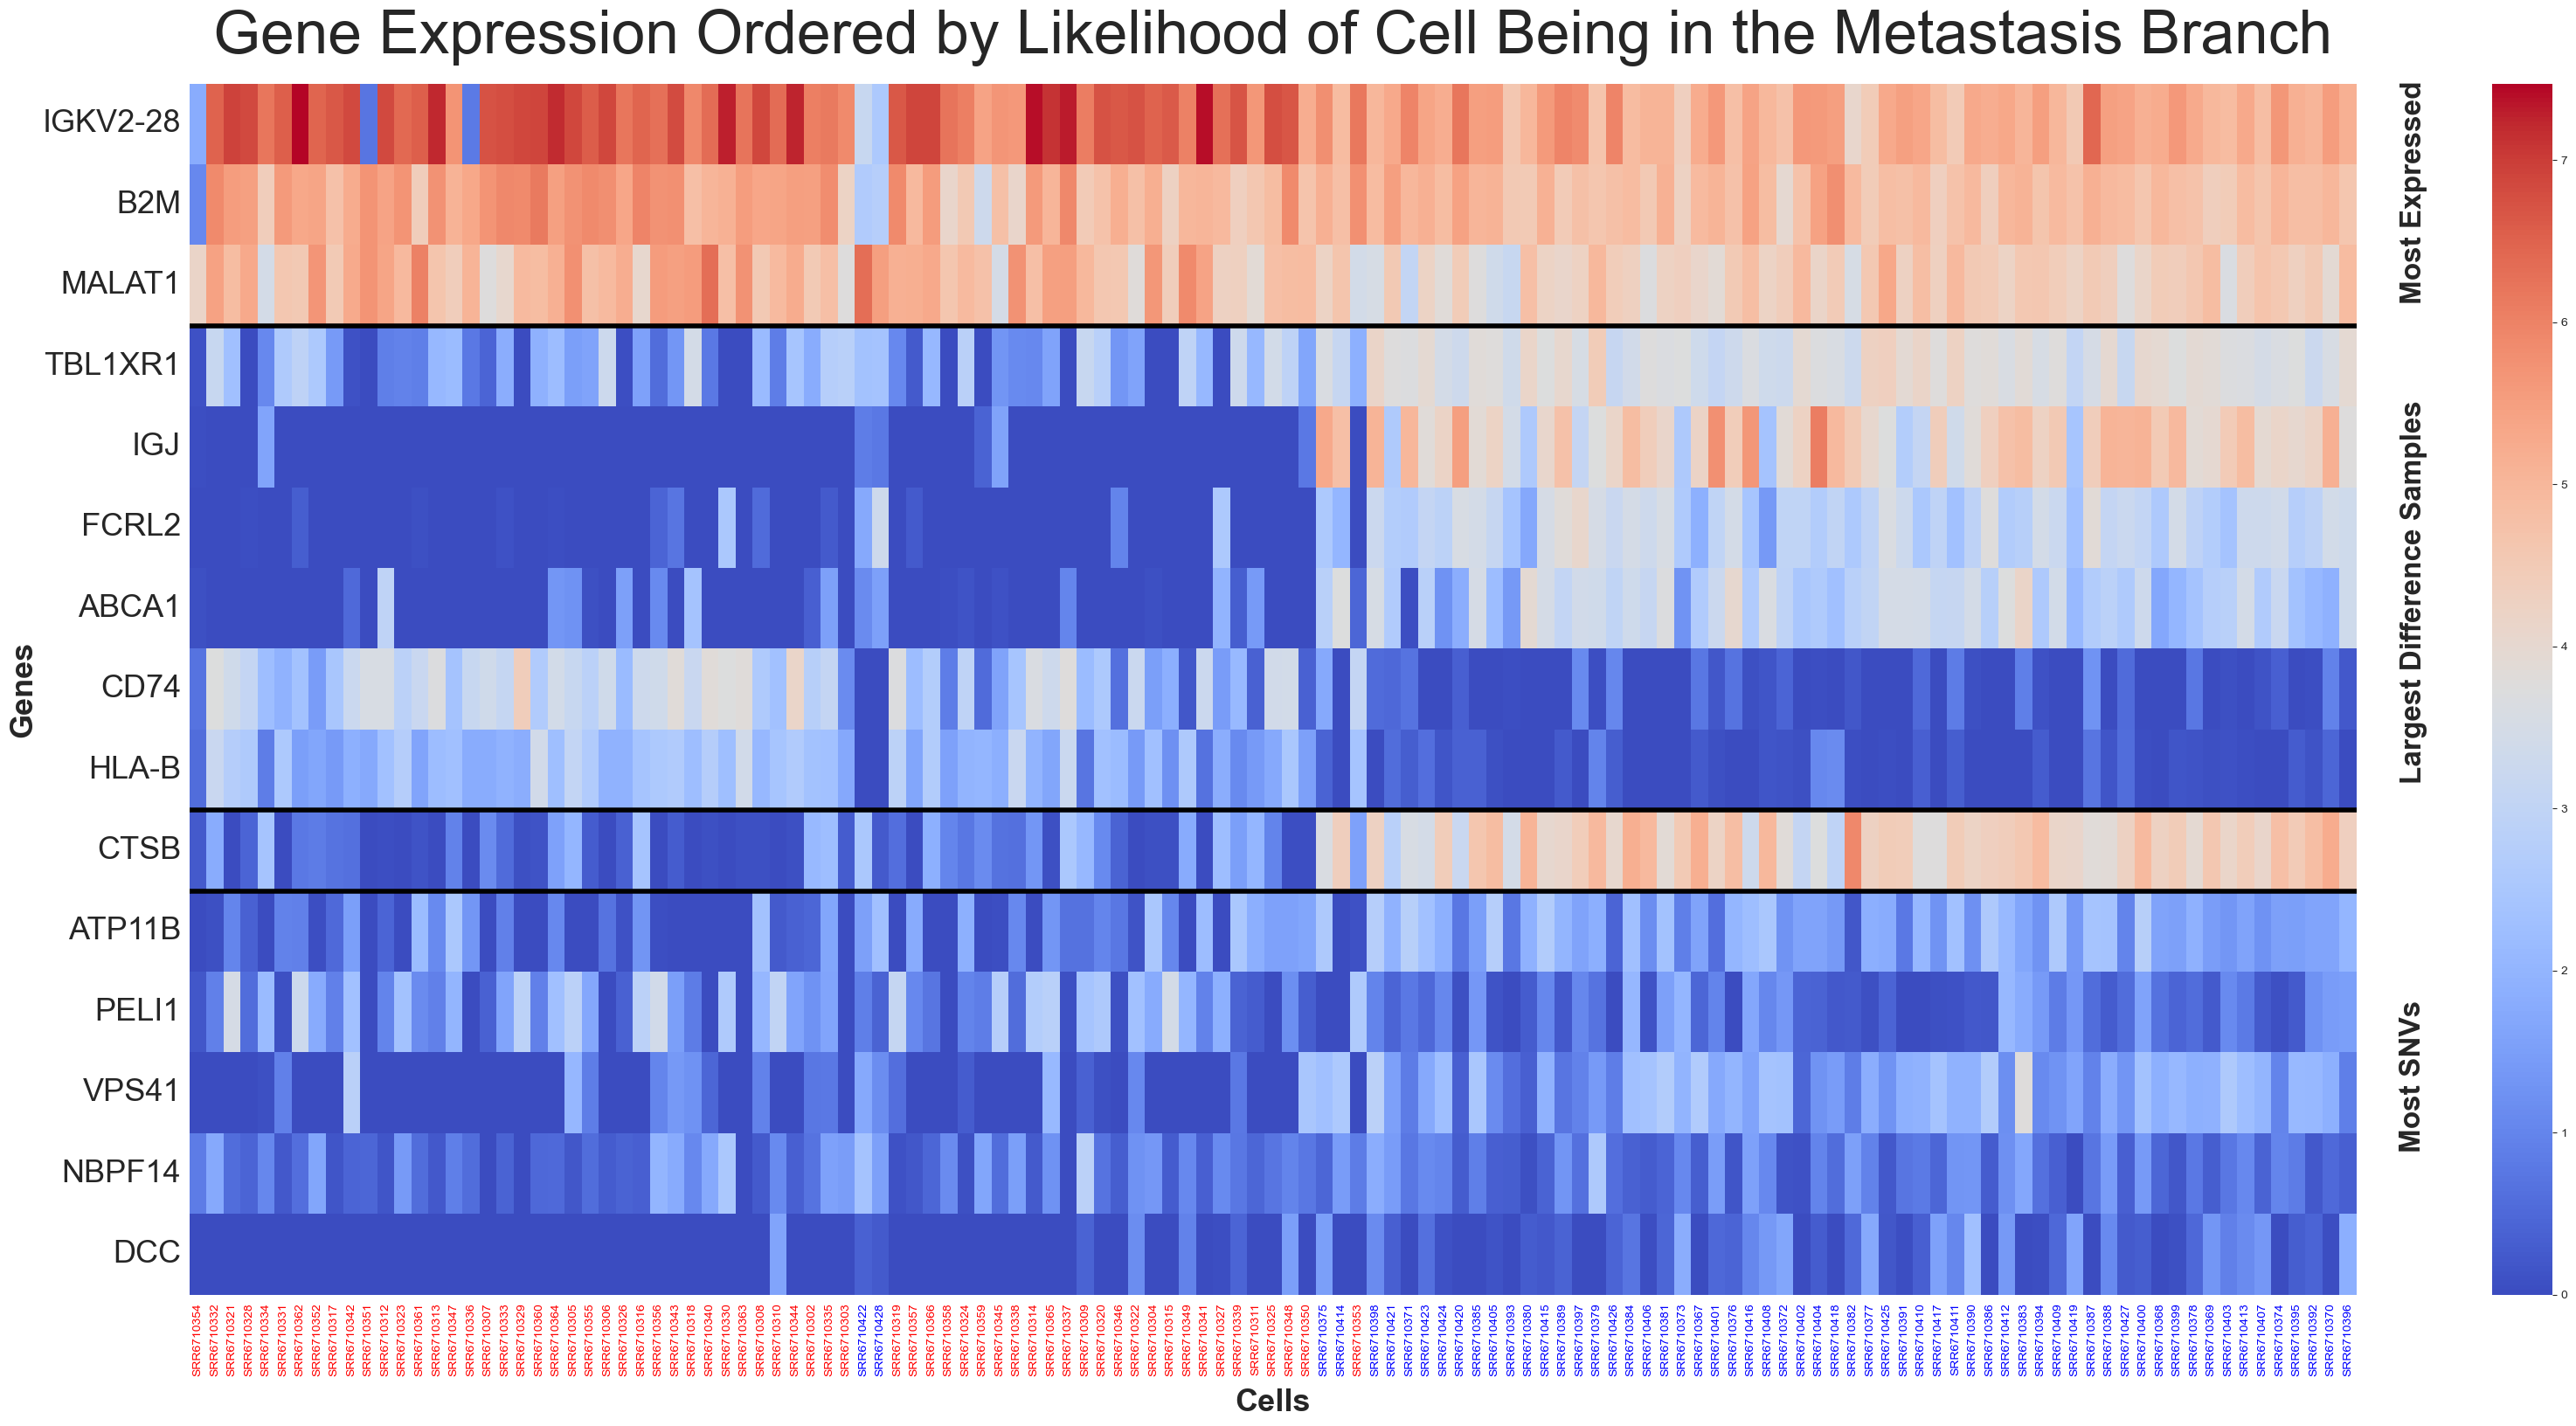

In [23]:
sorted_indices = np.argsort(posterior_node_after_branching)
mask_less_than_65 = sorted_indices < 65

plt.figure(figsize=(40, 16))

sorted_df = filtered_df_top_genes.iloc[:, sorted_indices]
col_colors = ['red' if val else 'blue' for val in mask_less_than_65]

plt.figure(figsize=(40, 18))
ax = sns.heatmap(sorted_df, cmap='coolwarm')

for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])
        
for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)   
    tick_label.set_rotation(0)
    
for idx in [3,9,10]:
    plt.hlines(idx, *plt.xlim(), color='black', linewidth=4)
    
plt.text(1.02, 0.91, "Most Expressed", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
plt.text(1.02, 0.58, "Largest Difference Samples", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
plt.text(1.02, 0.18, "Most SNVs", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
plt.title("Gene Expression Ordered by Likelihood of Cell Being in the Metastasis Branch", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=26, fontweight='bold')
plt.xlabel("Cells", fontsize=26, fontweight='bold', labelpad=10)
# plt.savefig(r"../data/results/figures/gene_expression.pdf", format="pdf")
plt.show()

In [24]:
middle_tree = 111
path = rf"../data/results/{study_num}/bootstrap_1000_snvs_3000_only_ref_to_alt"
reference = pd.read_csv(rf'../data/input_data/{study_num}/ref{reduced}.csv', index_col=0)
path_parent = os.path.join(path, "sciterna_parent_vec", f"sciterna_parent_vec_{middle_tree}.txt")
path_mut_loc = os.path.join(path, "sciterna_mut_loc", f"sciterna_mut_loc_{middle_tree}.txt")
path_selected = os.path.join(path, "sciterna_selected_loci", f"sciterna_selected_loci_{middle_tree}.txt")
parent_vec = np.loadtxt(path_parent, dtype=int)
mut_locs = np.loadtxt(path_mut_loc, dtype=int)
selected_mutations = np.loadtxt(path_selected, dtype=int)

selected_loci = reference.columns[selected_mutations]
selected_genes = convert_location_to_gene(selected_loci)

ctsb_indices = [n for n, c in enumerate(selected_genes) if "CTSB" in c]

In [27]:
n_cells = int(((len(parent_vec)+1)/2))
ct = CellTree(n_cells=n_cells, n_mut=0)
ct.use_parent_vec(parent_vec)
ct.mut_loc = mut_locs[ctsb_indices]

graph = ct.to_graphviz(gene_names=["C" for _ in range(3000)])
graph.attr(dpi='50')
graph.attr(rankdir='LR')

color_row = filtered_df_top_genes.loc["CTSB"].values
color_row = color_row / np.max(color_row)

cmap = plt.get_cmap('Greens')
colors = cmap(color_row)

for n in range(int((len(parent_vec)+1)/2)):
    rgba_color = colors[n]
    hex_color = mcolors.to_hex(rgba_color)

    if n < 65: # primary
        prob = (1000 - posterior_node_after_branching[n]) / 500
        graph.node(str(n), label="", shape='circle', style='filled', color="red", 
                   fillcolor=hex_color, fixedsize="true", width=str(prob), height=str(prob), penwidth="10")
    elif n >= 65 and reduced != "_reduced": # metastasis
        prob = posterior_node_after_branching[n] / 500
        graph.node(str(n), label="", shape='circle', style='filled', fillcolor=hex_color, 
                   color="blue", fixedsize="true", width=str(prob), height=str(prob), penwidth="15")
graph.attr(ratio="0.23") 

graph_file = "../data/results/figures/representative_tree"
# graph.render(graph_file, format='pdf', cleanup=True)

'..\\data\\results\\figures\\representative_tree.pdf'

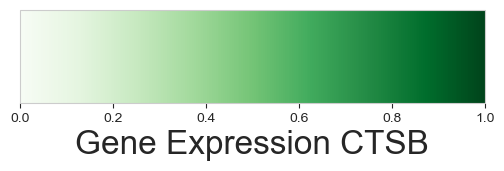

In [26]:
fig, ax = plt.subplots(figsize=(6, 1))
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=2, pad=0, aspect=5)
cbar.set_label('Gene Expression CTSB', fontsize=24)
cbar.ax.tick_params(labelsize=10)
ax.axis('off')
colorbar_path = os.path.join(path, "gene_expression_colorbar.svg")
plt.show()